# BADVFL

In [1]:
# Importing essential libraries and modules for deep learning and visualization
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset

from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}.")

Running on cuda.


In [2]:
# Fashion_MNIST
fashion_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=transform)
print("Train",trainset.data.shape,trainset.targets.shape)
print("Train",testset.data.shape,testset.targets.shape)

# Split of a little bit from the training data as the auxiliary dataset

aux_dataset_size = 100

auxset,trainset = torch.utils.data.random_split(trainset,(aux_dataset_size,len(trainset)-aux_dataset_size))

print("Trainset:",len(trainset))
print("Testset:",len(testset))
print("Auxset:",len(auxset))

Train torch.Size([60000, 28, 28]) torch.Size([60000])
Train torch.Size([10000, 28, 28]) torch.Size([10000])
Trainset: 59900
Testset: 10000
Auxset: 100


In [4]:
def split_data(dataset,K,axis):
    data = [ [] for _ in range(K) ]
    labels = [ [] for _ in range(K)]
    for i in range(len(dataset)):
        image,label = dataset[i]
        image = image[0]
        #print(image.shape)
        splits = torch.tensor_split(image,K,dim=axis)
        for i,s in enumerate(splits):
            data[i].append(s)
            labels[i].append(label)
        
    X = [
        torch.as_tensor(np.array(x)) for x in data
    ]
    Y = [
        torch.as_tensor(np.array(y)) for y in labels
    ]
    datasets = [
        TensorDataset(x,y) for x,y in zip(X,Y)
    ]
    return datasets
    
        
    


In [5]:
import random
def test(K,axis):
    datasets = split_data(trainset,K,axis)
    rand_idx = random.randrange(0,len(datasets[0]))
    print("#Datasets:",len(datasets))
    images = [
        datasets[i][rand_idx][0] for i in range(K)
    ]
    print(fashion_labels[datasets[0][rand_idx][1]])

    for im in images:
        print(im.shape,end=",")
        plt.imshow(im, cmap="gray")
        plt.show()
    if axis == 1:
        full_image = torch.hstack(images)
    elif axis == 0:
        full_image = torch.vstack(images)
    print("Full image shape:",full_image.shape)


    plt.imshow(full_image, cmap="gray")
    plt.show()

#Datasets: 4
Pullover
torch.Size([7, 28]),

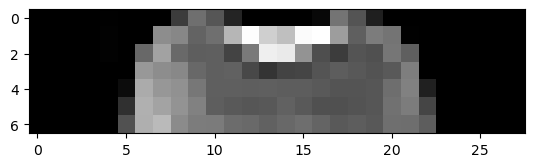

torch.Size([7, 28]),

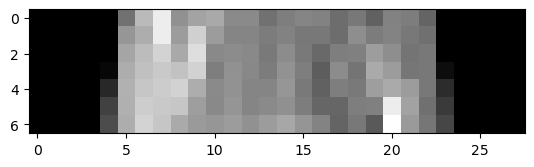

torch.Size([7, 28]),

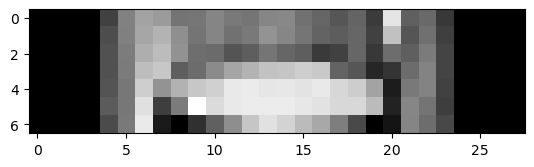

torch.Size([7, 28]),

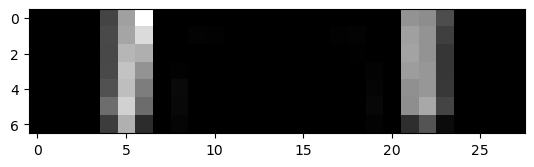

Full image shape: torch.Size([28, 28])


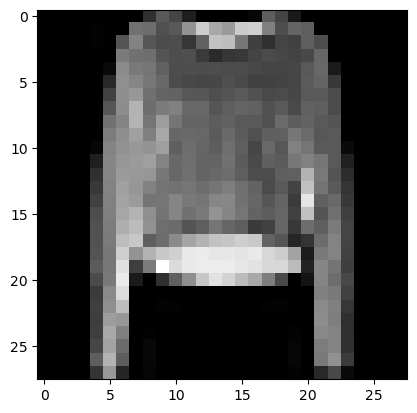

In [6]:
test(4,0)

#Datasets: 3
Dress
torch.Size([28, 10]),

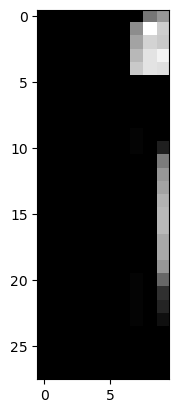

torch.Size([28, 9]),

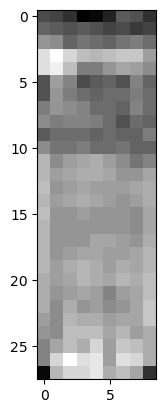

torch.Size([28, 9]),

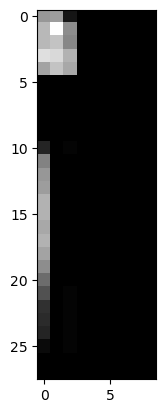

Full image shape: torch.Size([28, 28])


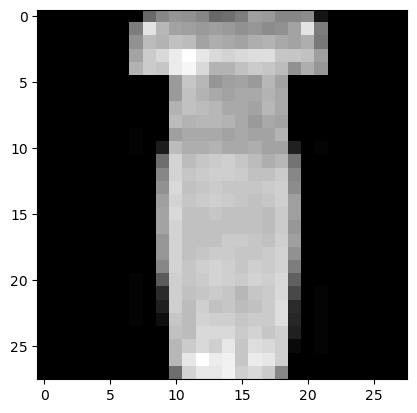

In [7]:
test(3,1)

## Setup VFL

In [8]:
class Client():
    def __init__(self,traindata,testdata,model):
        self.training_data = traindata
        self.test_data = testdata
        self.model = model
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.001)
        
    def forward_pass(self,indices, train = True):
        if train:
            data = self.training_data[indices][0]
            self.model.train()
        else:
            data = self.test_data[indices][0]
            self.model.eval()
        data = data.unsqueeze(1)
        data = data.to(device)

        return self.model(data)

    def zero_grad(self):
        self.optimizer.zero_grad()
    
    def __repr__(self):
        return f"Client with {len(self.training_data)} training images and {len(self.test_data)} test images of shape {self.training_data[0][0].shape}"

In [9]:
class Server():
    def __init__(self,trainlabels,testlabels,model, clients,train_batch_size = 64, test_batch_size = 64):
        self.trainlabels = trainlabels
        self.testlabels = testlabels
        self.model = model
        self.train_batch_size = train_batch_size
        self.test_batch_size = test_batch_size
        self.clients = clients
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.001)
        self.loss_function = nn.CrossEntropyLoss()
        
    def forward(self,indices, train=True):
        embeddings = [
            c.forward_pass(indices,train=train) for c in clients
        ]
        concat = torch.hstack(embeddings) # Concat feature vectors that are the output from the clients

        return self.model(concat)

    def train_epoch(self,):
        self.model.train()
        dataset_size = self.trainlabels.size()[0]
        permutation = torch.randperm(dataset_size)
        for i in tqdm(range(0,dataset_size,self.train_batch_size)):
            self.optimizer.zero_grad()
            for c in clients:
                c.zero_grad()
            indices = permutation[i:i+self.train_batch_size]
            correct_labels = self.trainlabels[indices].to(device)
            prediction = self.forward(indices,train=True)
            loss = self.loss_function(prediction,correct_labels)
            loss.backward()
            self.optimizer.step()
            for c in clients:
                c.optimizer.step()
    def eval(self):
        # Lists to store all predictions and true labels
        all_preds = []
        all_labels = []
        dataset_size = self.testlabels.size()[0]
        self.model.eval()
        permutation = range(0,dataset_size)
        for i in range(0,dataset_size,self.test_batch_size):
            indices = permutation[i:i+self.train_batch_size]
            correct_labels = self.testlabels[indices]
            outputs = self.forward(indices,train=False)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(correct_labels.cpu().numpy())
        print(classification_report(all_labels, all_preds, target_names=fashion_labels))
        
    def __repr__(self):
        return f"Server with {len(self.trainlabels)} training labels and {len(self.testlabels)} test labels and {len(self.clients)} clients."

In [10]:
class FFClientModel(nn.Module):
    def __init__(self,input_size):
        super(FFClientModel, self).__init__()
        self.input_size = input_size
        print(input_size)
        self.fc1 = nn.Linear(self.input_size,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,128)
    def forward(self,x):
        x = x.view(-1, self.input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

class ClientModel(nn.Module):
    def __init__(self):
        super(ClientModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) 
        self.conv2 = nn.Conv2d(32, 64, 3)

        self.fc1 = nn.Linear(640, 128) 

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 640)
        x = F.relu(self.fc1(x))
        return x
    

In [11]:
class GlobalModel(nn.Module):
    def __init__(self,num_clients):
        super(GlobalModel, self).__init__()
        self.fc1 = nn.Linear(num_clients * 128, 128)  # Client model has 128 output features, 128*#clients must match the input for the global model
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x)) 
        x = self.fc3(x)

        return F.log_softmax(x, dim=1)

In [12]:
num_clients = 2
train_datasets = split_data(trainset,num_clients,0)
test_datasets = split_data(testset,num_clients,0)
aux_datasets = split_data(auxset,num_clients,0)

train_labels = train_datasets[0][:][1][:].clone() # All datasets have the same labels, copy the labels from the first dataset for the server to keep
test_labels = test_datasets[0][:][1][:].clone() # All datasets have the same labels, copy the labels from the first dataset for the server to keep
for train,test in zip(train_datasets,test_datasets):
    train[:][1][:] = 0 # Set labels to 0 to prevent cheating
    #test[:][1][:] = 0 # Set labels to 0 to prevent cheating
# Only the malicious client(s) gets to keep the labels for the aux dataset(s)

In [13]:
train_labels

tensor([2, 5, 8,  ..., 1, 3, 8])

In [14]:
ds = train_datasets[0]
size = ds[0][0].shape.numel()
print(size)

392


In [15]:
clients = [
    Client(train,test,FFClientModel(train[0][0].shape.numel()).to(device)) for train,test in zip(train_datasets,test_datasets)
]
for c in clients:
    print(c)
server = Server(train_labels,test_labels,GlobalModel(len(clients)).to(device), clients)
print(server)

392
392
Client with 59900 training images and 10000 test images of shape torch.Size([14, 28])
Client with 59900 training images and 10000 test images of shape torch.Size([14, 28])
Server with 59900 training labels and 10000 test labels and 2 clients.


In [16]:
epochs = 10
for i in range(epochs):
    print(f"Epoch {i}")
    server.train_epoch()

Epoch 0


  0%|          | 0/936 [00:00<?, ?it/s]

Epoch 1


  0%|          | 0/936 [00:00<?, ?it/s]

Epoch 2


  0%|          | 0/936 [00:00<?, ?it/s]

Epoch 3


  0%|          | 0/936 [00:00<?, ?it/s]

Epoch 4


  0%|          | 0/936 [00:00<?, ?it/s]

Epoch 5


  0%|          | 0/936 [00:00<?, ?it/s]

Epoch 6


  0%|          | 0/936 [00:00<?, ?it/s]

Epoch 7


  0%|          | 0/936 [00:00<?, ?it/s]

Epoch 8


  0%|          | 0/936 [00:00<?, ?it/s]

Epoch 9


  0%|          | 0/936 [00:00<?, ?it/s]

In [17]:
server.eval()

              precision    recall  f1-score   support

 T-shirt/top       0.86      0.79      0.82      1000
     Trouser       0.97      0.98      0.98      1000
    Pullover       0.78      0.82      0.80      1000
       Dress       0.87      0.91      0.89      1000
        Coat       0.83      0.75      0.79      1000
      Sandal       0.95      0.98      0.96      1000
       Shirt       0.66      0.74      0.70      1000
     Sneaker       0.96      0.92      0.94      1000
         Bag       0.99      0.96      0.98      1000
  Ankle boot       0.95      0.96      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [98]:
class BadVFLClient(Client):
    def __init__(self,traindata,testdata,aux_data,model):
        self.training_data = traindata
        self.test_data = testdata
        self.model = model
        self.aux_data = aux_data
        self.train_batch_size = 20
        self.test_batch_size = 64
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.001)
        
    def estimate_top_model(self,num_epochs):
        top_model = GlobalModel(1).to(device)
        loss_function = nn.CrossEntropyLoss()

        top_model.train()
        self.model.eval()
        top_optimizer = torch.optim.Adam(top_model.parameters(),lr=0.001)
        dataset_size = len(self.aux_data)
        print("Estimating top model")
        for epoch in tqdm(range(num_epochs)):
            permutation = torch.randperm(dataset_size)
            for i in range(0,dataset_size,self.train_batch_size):
                top_optimizer.zero_grad()
                indices = permutation[i:i+self.train_batch_size]
                correct_labels = self.aux_data[indices][1].to(device)
                data = self.aux_data[indices][0]
                data = data.unsqueeze(1)
                data = data.to(device)
                embeddings = self.model(data)
                output = top_model(embeddings)
                loss = loss_function(output,correct_labels)
                loss.backward()
                top_optimizer.step()
        self.top_model = top_model
        return top_model

    def predict_train_labels(self):
        dataset_size = len(self.training_data)
        permutation = range(dataset_size)
        all_labels = []
        for i in range(0,dataset_size,self.train_batch_size):
            indices = permutation[i:i+self.train_batch_size]
            data = self.training_data[indices][0]
            data = data.to(device)
            embeddings = self.model(data)
            outputs = self.top_model(embeddings)
            _, predicted = torch.max(outputs, 1)
            predicted = predicted.cpu()
            all_labels.extend(predicted.cpu().numpy())
        self.training_data[:][1][:] = torch.as_tensor(np.array(all_labels))
        print(self.training_data[:][1])
    def evaluate_top_model(self):
        # Lists to store all predictions and true labels
        all_preds = []
        all_labels = []
        dataset_size = len(self.test_data)
        print(f"test:{dataset_size}")
        self.model.eval()
        self.top_model.eval()
        permutation = range(0,dataset_size)
        for i in range(0,dataset_size,self.test_batch_size):
            indices = permutation[i:i+self.train_batch_size]
            correct_labels = self.test_data[indices][1]
            embeddings = self.forward_pass(indices,train=False)
            outputs = self.top_model(embeddings)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(correct_labels.cpu().numpy())

        
        print(classification_report(all_labels, all_preds, target_names=fashion_labels))

    def __repr__(self):
        output = f"BadVFLClient with {len(self.training_data)} training images and {len(self.test_data)} test images of shape {self.training_data[0][0].shape}\n"
        output += f"Aux dataset length : {len(self.aux_data)}, shape : {self.aux_data[0][0].shape}"
        return output
            

In [99]:
clients = [
    Client(train,test,FFClientModel(train[0][0].shape.numel()).to(device)) for train,test in zip(train_datasets,test_datasets)
]
train = train_datasets[0]
test = test_datasets[0]
aux = aux_datasets[0]

bad_client = BadVFLClient(train,test,aux,FFClientModel(train[0][0].shape.numel()).to(device))
clients[0] = bad_client

for c in clients:
    print(c)
server = Server(train_labels,test_datasets[0][:][1],GlobalModel(len(clients)).to(device), clients)
print(server)

392
392
392
BadVFLClient with 59900 training images and 10000 test images of shape torch.Size([14, 28])
Aux dataset length : 100, shape : torch.Size([14, 28])
Client with 59900 training images and 10000 test images of shape torch.Size([14, 28])
Server with 59900 training labels and 10000 test labels and 2 clients.


In [100]:
train_labels

tensor([2, 5, 8,  ..., 1, 3, 8])

In [101]:
epochs = 1
for i in range(epochs):
    print(f"Epoch {i}")
    server.train_epoch()

Epoch 0


  0%|          | 0/936 [00:00<?, ?it/s]

In [102]:
bad_client.estimate_top_model(20)
bad_client.evaluate_top_model()
bad_client.predict_train_labels()

Estimating top model


  0%|          | 0/20 [00:00<?, ?it/s]

test:10000
              precision    recall  f1-score   support

 T-shirt/top       0.47      0.66      0.55       308
     Trouser       0.71      0.80      0.76       325
    Pullover       0.47      0.48      0.47       327
       Dress       0.65      0.68      0.66       330
        Coat       0.48      0.65      0.56       321
      Sandal       0.89      0.88      0.89       304
       Shirt       0.11      0.02      0.04       309
     Sneaker       0.83      0.89      0.86       304
         Bag       0.97      0.77      0.86       316
  Ankle boot       0.91      0.87      0.89       292

    accuracy                           0.67      3136
   macro avg       0.65      0.67      0.65      3136
weighted avg       0.65      0.67      0.65      3136

tensor([4, 5, 6,  ..., 1, 3, 6])
